Threat detection by Video classification with alert system

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
import smtplib
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2539520/45929032 bytes (5.5%)5922816/45929032 bytes (12.9%)9314304/45929032 bytes (20.3%)12713984/45929032 bytes (27.7%)16105472/45929032 bytes (35.1%)19472384/45929032 bytes (42.4%)22814720/45929032 bytes (49.7%)25649152/45929032 bytes (55.8%)28925952/45929032 bytes (63.0%)32268288/45929032 bytes (70.3%)35749888/45929032 bytes (77.8%)39026688/45929032 bytes (85.0%)

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Extracting the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive link of the dataset

In [4]:
path = '/content/drive/MyDrive/ML Personal/Datasets/Hackathon_Dataset'

Function to print the first frame of a random video of each class from the dataset

In [5]:
def getFirstFrame(index):

  # Get Names of all classes in the main directory
  all_classes_names = os.listdir(path)

  print(all_classes_names)

  # Getting Class Name using Random Index
  selected_class_Name = all_classes_names[index]

  # Getting a list of all the video files present in a Class Directory
  video_files_names_list = os.listdir(path +'/'+selected_class_Name)

  # Randomly selecting a video file
  selected_video_file_name = random.choice(video_files_names_list)

  print(path +'/'+selected_class_Name + '/' + selected_video_file_name)

  # Reading the Video File Using the Video Capture
  video_reader = cv2.VideoCapture(path + '/' +selected_class_Name + '/' + selected_video_file_name)

  # Reading The First Frame of the Video File
  _, bgr_frame = video_reader.read()

  # Closing the VideoCapture object and releasing all resources. 
  video_reader.release()

  # Converting the BGR Frame to RGB Frame 
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Adding The Class Name Text on top of the Video Frame.
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

  # Assigning the Frame to a specific position of a subplot
  plt.subplot(1, 3, 1)
  plt.imshow(rgb_frame)
  plt.axis('off')

['Non Threat', 'Threat']
/content/drive/MyDrive/ML Personal/Datasets/Hackathon_Dataset/Non Threat/NV_86.mp4


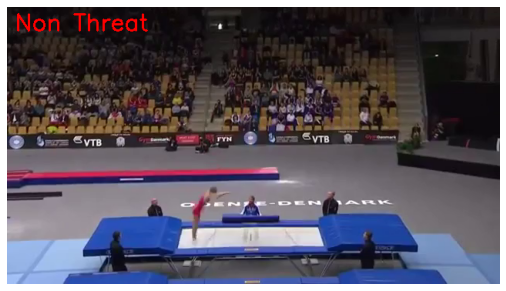

In [8]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
getFirstFrame(0)

['Non Threat', 'Threat']
/content/drive/MyDrive/ML Personal/Datasets/Hackathon_Dataset/Threat/V_60.mp4


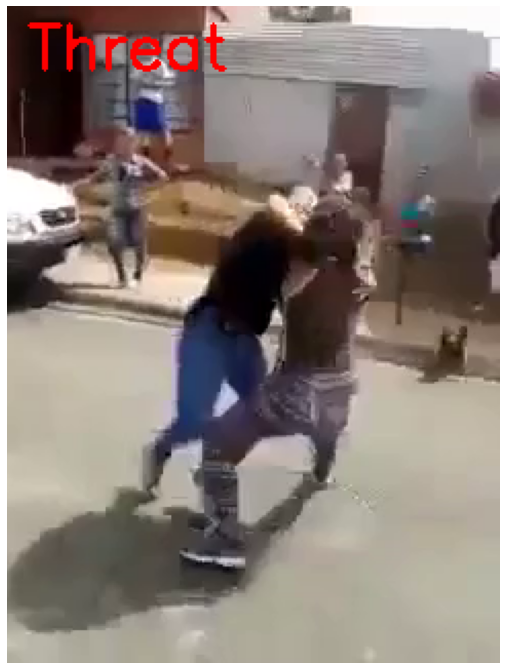

In [10]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
getFirstFrame(1)

In [11]:
image_height, image_width = 64, 64
max_images_per_class = 1000

dataset_directory = path
classes_list = ['Threat','Non Threat']

model_output_size = len(classes_list)

Function to perform Frame Extraction

In [12]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

Funtion to create the dataset by extracting the features of the frames of each video from the original dataset

In [13]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [14]:
features, labels = create_dataset()

Extracting Data of Class: Threat
Extracting Data of Class: Non Threat


In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Splitting train and test data

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

Model creation

In [17]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

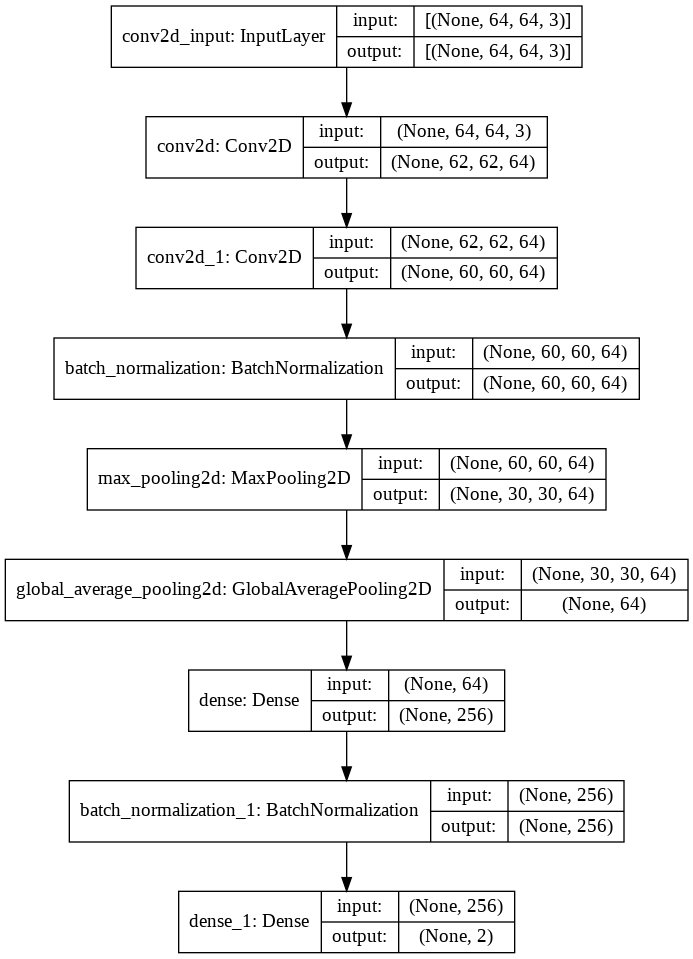

In [18]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

Training the model

In [19]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
320/320 [==============================] - 39s 117ms/step - loss: 0.6934 - accuracy: 0.6070 - val_loss: 1.1365 - val_accuracy: 0.4969
Epoch 2/50
320/320 [==============================] - 37s 116ms/step - loss: 0.6412 - accuracy: 0.6500 - val_loss: 0.7140 - val_accuracy: 0.5719
Epoch 3/50
320/320 [==============================] - 37s 116ms/step - loss: 0.6184 - accuracy: 0.6594 - val_loss: 0.5356 - val_accuracy: 0.7094
Epoch 4/50
320/320 [==============================] - 37s 116ms/step - loss: 0.5939 - accuracy: 0.6687 - val_loss: 1.0426 - val_accuracy: 0.6000
Epoch 5/50
320/320 [==============================] - 37s 115ms/step - loss: 0.6002 - accuracy: 0.6812 - val_loss: 0.7411 - val_accuracy: 0.5844
Epoch 6/50
320/320 [==============================] - 37s 115ms/step - loss: 0.5725 - accuracy: 0.7031 - val_loss: 0.9366 - val_accuracy: 0.6031
Epoch 7/50
320/320 [==============================] - 37s 115ms/step - loss: 0.5564 - accuracy: 0.7117 - val_loss: 0.5014 - val_ac

Evaluating the model

In [20]:
model_evaluation_history = model.evaluate(features_test, labels_test)

13/13 [==============================] - 3s 196ms/step - loss: 0.2139 - accuracy: 0.9150


Saving the model

In [21]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

Function to plot the various parameters of the model

In [22]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

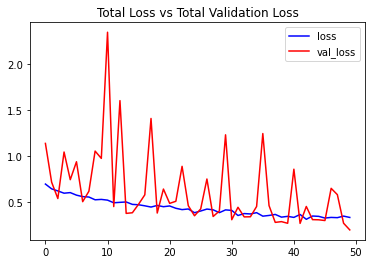

In [23]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

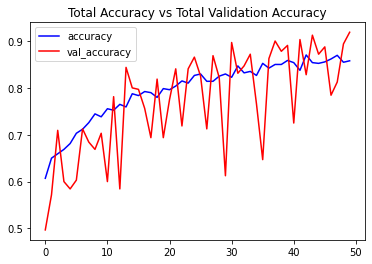

In [24]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Function to perform classfication of CCTV Footages

In [25]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    result = []

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        result.append(predicted_class_name)

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

    return result

Drive link containing all the CCTV footages across the city

In [26]:
cctv = '/content/drive/MyDrive/ML Personal/Datasets/CCTV'

Function to send alert mail to the concerned officials

In [30]:
def send_alert_email(video):
  # creates SMTP session
  s = smtplib.SMTP('smtp.gmail.com', 587)

  # start TLS for security
  s.starttls()

  # Authentication
  s.login("dummy.mail.pwdreset@gmail.com", "pwdreset")

  # message to be sent
  message = 'This is a threat alert message. The footages in '+str(video)+' has been classified as a potential threat. Please review the footages and take necessary actions if required'

  # sending the mail
  s.sendmail("dummy.mail.pwdreset@gmail.com", "dummy.mail.pwdreset@gmail.com", message)

  # terminating the session
  s.quit()


Classification of all the CCTV footages

In [31]:
videos = os.listdir(cctv)
potential_threat_videos = []

for video in videos:

  input_video_file_path = cctv + '/' + video

  # Calling The Make Average Method To Start The Process
  result = make_average_predictions(input_video_file_path, 50)

  isThreat = False

  if result[0] == 'Threat':
    isThreat = True

  if isThreat:
    print(video + ' - ' + 'Threat')
    send_alert_email(video)
    potential_threat_videos.append(video)

  else:
    print(video + ' - ' + 'No Threat')


CAM_01.mp4 - Threat
CAM_02.mp4 - No Threat
CAM_04.mp4 - No Threat
CAM_03.mp4 - No Threat
CAM_06.mp4 - No Threat
CAM_05.mp4 - No Threat
CAM_07.mp4 - No Threat
CAM_08.mp4 - No Threat
CAM_11.mp4 - No Threat
CAM_10.mp4 - No Threat
CAM_09.mp4 - Threat
CAM_15.mp4 - Threat
CAM_16.mp4 - No Threat
CAM_12.mp4 - No Threat
CAM_14.mp4 - No Threat
CAM_13.mp4 - Threat
CAM_17.mp4 - Threat
CAM_18.mp4 - No Threat
CAM_19.mp4 - Threat
CAM_23.mp4 - Threat
CAM_22.mp4 - Threat
CAM_20.mp4 - Threat
CAM_21.mp4 - No Threat
CAM_27.mp4 - No Threat
CAM_25.mp4 - No Threat
CAM_26.mp4 - No Threat
CAM_24.mp4 - Threat
CAM_29.mp4 - Threat
CAM_28.mp4 - Threat
CAM_30.mp4 - No Threat
CAM_32.mp4 - Threat
CAM_31.mp4 - Threat
CAM_33.mp4 - Threat
CAM_36.mp4 - No Threat
CAM_37.mp4 - No Threat
CAM_35.mp4 - No Threat
CAM_34.mp4 - No Threat
CAM_38.mp4 - Threat
CAM_41.mp4 - Threat
CAM_39.mp4 - Threat
CAM_40.mp4 - No Threat
CAM_42.mp4 - Threat
CAM_43.mp4 - Threat
CAM_44.mp4 - Threat
CAM_45.mp4 - Threat
CAM_46.mp4 - Threat
CAM_48.mp4 

In [32]:
len(potential_threat_videos)

63